In [1]:
# Cell 1: Install dependencies (run once)
%pip install numpy pandas transformers scikit-learn faiss-cpu gensim datasets networkx matplotlib seaborn tqdm ipython sentencepiece torch torchvision torchaudio ipywidgets


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Cell 2: Import libraries
import numpy as np
import pandas as pd
from transformers import T5Tokenizer, T5ForConditionalGeneration
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
import faiss
import networkx as nx
from gensim.models import Word2Vec
from datasets import load_dataset
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import ipywidgets

%matplotlib inline 

In [3]:
# Cell 3: Load and preprocess data
print("Loading synthetic dataset...")
dataset = load_dataset("ilsilfverskiold/linkedin_profiles_synthetic")
df = pd.DataFrame(dataset['train'])
df['user_type'] = np.random.choice(['student', 'alumni', 'officer'], len(df))
display(df.head()) # Display sample data

Loading synthetic dataset...


Using the latest cached version of the dataset since ilsilfverskiold/linkedin_profiles_synthetic couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /Users/adarshkumardalai/.cache/huggingface/datasets/ilsilfverskiold___linkedin_profiles_synthetic/default/0.0.0/fd1478676dbff8c95835fa3cff1b8f0a5a40d9cc (last modified on Sun Feb  2 15:51:33 2025).


,FirstName,LastName,Headline,Location,About Me,Experience,Education,Skills,Certifications,Recommendations,...,embeddings_nv-embedqa-e5-v5,embeddings_bge-m3,embeddings_arctic-embed-l,embeddings_mistral-7b-v2,embeddings_gte-large-en-v1.5,embeddings_text-embedding-ada-002,embeddings_text-embedding-3-small,embeddings_voyage-3,embeddings_mxbai-embed-large-v1,user_type
0,Zachariah,Witting,Augmented Reality Developer | Creating Immersi...,"Zurich, Switzerland",Dedicated and innovative AR developer with a p...,"Senior AR Developer | Pixelloid | Zurich, Swit...",ETH Zurich | Bachelor of Science in Computer S...,Unity; ARKit; ARCore; C#; Java; JavaScript; We...,Certified AR Developer | Unity Technologies | ...,"Benjamin Ryder | Lead Developer, Breadwinner S...",...,"[-0.0040283203125, -0.0135040283203125, -0.013...","[-0.0714111328125, -0.032958984375, 0.00956726...","[0.0011386871337890625, -0.0296630859375, 0.01...","[0.0209808349609375, 0.00884246826171875, -0.0...","[0.0010018084, 0.03207807, 0.0020768428, 0.008...","[-0.012569249, -0.0014929766, -0.0005262406, -...","[-0.03209501, -0.0011106498, 0.024465062, 0.02...","[-0.010514396, -0.054661196, 0.0013718046, 0.0...","[0.016271759, 0.008558619, -0.06318841, -0.038...",alumni
1,Yvonne,Hofmann,UI Designer | Crafting Human-Centered Digital ...,"Zurich, Switzerland",As a UI Designer with a passion for human-cent...,"Senior UI Designer at EVONIK | EVONIK | Essen,...",Hochschule für Gestaltung und Kunst | Bachelor...,User Experience Design; Visual Design; Human-C...,Certified UX Designer | Nielsen Norman Group |...,Yvonne is a talented and dedicated designer wh...,...,"[0.010345458984375, -0.04058837890625, 0.04122...","[-0.0811767578125, -0.048858642578125, -0.0326...","[0.00482177734375, -0.0362548828125, 0.0547180...","[0.0004520416259765625, 0.022918701171875, -0....","[0.01612412, -0.012229308, -0.0012095612, 0.03...","[-0.007296344, -0.036226414, -0.012892894, 5.2...","[-0.02247679, -0.00025442478, 0.024274934, 0.0...","[-0.015455144, -0.0051680231, 0.028300855, 0.0...","[-0.041409347, -0.014491842, -0.070636116, -0....",alumni
2,Yves,Laurent,Co-Founder AI Product | Transforming Industrie...,"Zurich, Switzerland",Results-driven technology entrepreneur with a ...,Mindera | Co-Founder and Head of AI Product | ...,EPFL | Master of Science in Computer Science |...,AI Strategy; Machine Learning; Deep Learning; ...,AWS Certified Developer - Associate; Google Cl...,Pierre Dupont | CTO at Mindera | Yves has been...,...,"[-0.0260467529296875, 0.009124755859375, -0.03...","[-0.05426025390625, -0.0178375244140625, -0.02...","[-0.023040771484375, -0.006618499755859375, -0...","[0.00290679931640625, -0.0150604248046875, -0....","[-0.0064060865, 0.038315836, -0.01249036, 0.01...","[0.0013401911, -0.02315128, 0.021068081, -0.01...","[0.014104838, -0.02102309, 0.028816335, 0.0099...","[0.0065766545, -0.057736553, 0.026976572, 0.04...","[0.012321422, 0.012636202, -0.02650155, -0.029...",alumni
3,Yves,Thibault,NLP Specialist | Helping businesses unlock ins...,"Zurich, Switzerland",I'm a seasoned NLP professional with a passion...,"Senior NLP Engineer, IBM Research | IBM | Zuri...",École Polytechnique Fédérale de Lausanne (EPFL...,NLP; Deep Learning; Natural Language Generatio...,Google Cloud Certified - Professional Data Eng...,"Dr. Maria Rodriguez, Research Director, IBM | ...",...,"[-0.0144195556640625, -0.0172271728515625, -0....","[-0.06982421875, -0.0027370452880859375, 0.013...","[-0.00853729248046875, -0.02984619140625, 0.02...","[0.008544921875, -0.005107879638671875, -0.029...","[-0.0046507316, 0.044952057, -0.041179296, -0....","[-0.022266217, 0.008473045, 0.034567323, -0.01...","[-0.0656291, -0.017954687, 0.049091894, -0.027...","[0.002940885, -0.05102396, 0.050508436, 0.0008...","[-0.0009468875, -0.010518525, -0.059485085, -0...",alumni
4,Yves,Bonnard,Advertising Manager | Driving Brand Growth Thr...,"Zurich, Switzerland",Results-driven Advertising Manager with 8+ yea...,Advertising Man

In [2]:
# Cell 4: T5 setup for NLP
tokenizer = T5Tokenizer.from_pretrained('t5-small')
model = T5ForConditionalGeneration.from_pretrained('t5-small')

def summarize_profile(text):
    try:
        input_text = f"summarize: {text}"
        inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True)
        summary_ids = model.generate(inputs['input_ids'], max_length=50, num_beams=4, early_stopping=True)
        return tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    except Exception as e:
        print(f"Error summarizing: {e}")
        return text

print("Summarizing profiles...")
tqdm.pandas() # Enable progress bar for pandas
df['summary'] = df['Headline'].progress_apply(summarize_profile)
display(df[['Headline', 'summary']].head())

NameError: name 'T5Tokenizer' is not defined

In [ ]:
# Cell 5: Generate embeddings
def generate_t5_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    outputs = model.encoder(**inputs).last_hidden_state.mean(dim=1).detach().numpy()
    return outputs[0]

print("Generating T5 embeddings...")
df['headline_embedding'] = [generate_t5_embeddings(text) for text in tqdm(df['Headline'])]
df['summary_embedding'] = [generate_t5_embeddings(text) for text in tqdm(df['summary'])]

# Combine embeddings
df['combined_embedding'] = df.apply(lambda row: np.mean([row['headline_embedding'], row['summary_embedding']], axis=0), axis=1)
all_embeddings = normalize(np.stack(df['combined_embedding'].values))
print(f"Embeddings shape: {all_embeddings.shape}")

Generating T5 embeddings...


  0%|          | 0/6904 [00:00<?, ?it/s]

  0%|          | 0/6904 [00:00<?, ?it/s]

Embeddings shape: (6904, 512)


In [ ]:
# Cell 6: FAISS index for similarity search
index = faiss.IndexFlatL2(all_embeddings.shape[1])
index.add(all_embeddings)
print("FAISS index created with", index.ntotal, "vectors.")

FAISS index created with 6904 vectors.


Building graph edges...


  0%|          | 0/6904 [00:00<?, ?it/s]

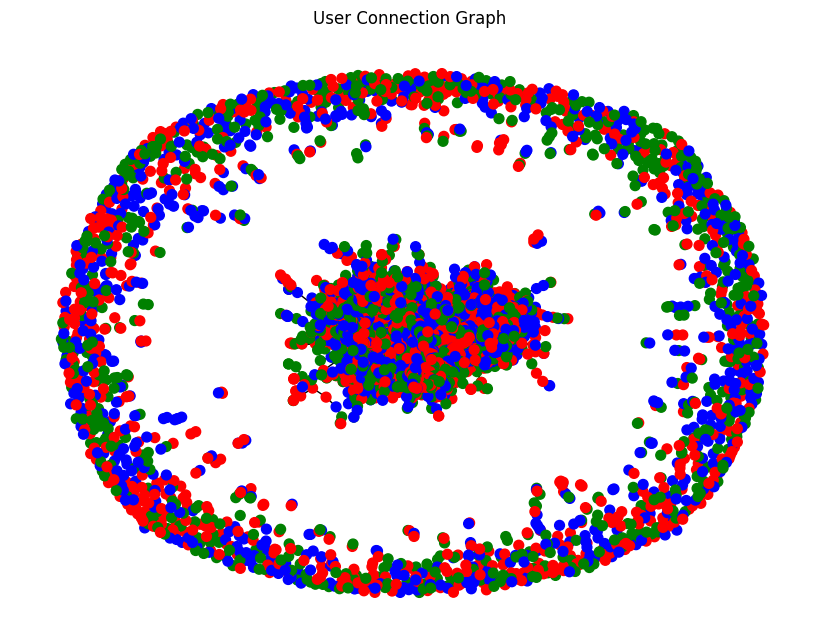

In [ ]:
# Cell 7: Graph-based matching
G = nx.Graph()
for i, row in df.iterrows():
    G.add_node(i, user_type=row['user_type'], embedding=row['combined_embedding'])

print("Building graph edges...")
for i in tqdm(range(len(df))):
    for j in range(i + 1, min(i + 50, len(df))): # Limit comparisons for speed
        sim = cosine_similarity([all_embeddings[i]], [all_embeddings[j]])[0][0]
        if sim > 0.8:
            G.add_edge(i, j, weight=sim)

# Visualize graph (small subset)
plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=False, node_size=50, node_color=df['user_type'].map({'student': 'blue', 'alumni': 'green', 'officer': 'red'}))
plt.title("User Connection Graph")
plt.show()

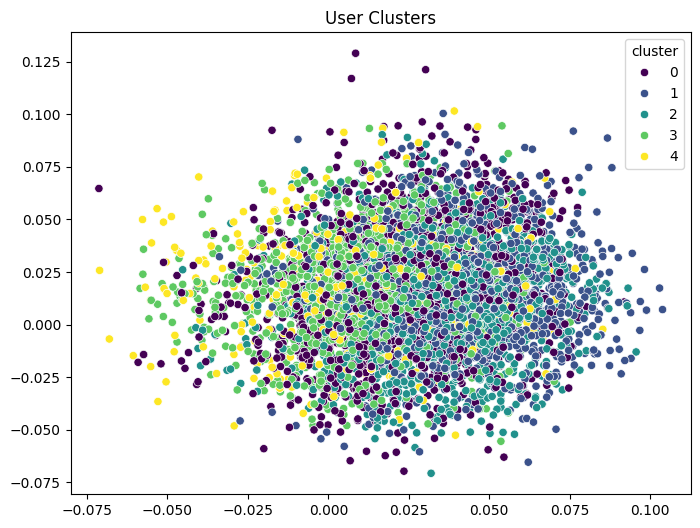

In [ ]:
# Cell 8: Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(all_embeddings)

# Visualize clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=all_embeddings[:, 0], y=all_embeddings[:, 1], hue=df['cluster'], palette='viridis')
plt.title("User Clusters")
plt.show()

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Function to analyze prompt and extract requirements
def analyze_prompt(prompt):
    input_text = f"extract_keywords: {prompt}"
    inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True)
    output_ids = model.generate(inputs['input_ids'], max_length=50, num_beams=4, early_stopping=True)
    keywords = tokenizer.decode(output_ids[0], skip_special_tokens=True).split(", ")
    prompt_embedding = generate_t5_embeddings(prompt)
    return keywords, prompt_embedding

# Enhanced recommendation function with prompt priority
def recommend_with_prompt(user_idx, prompt, top_n=5):
    # Step 1: Analyze prompt
    print(f"Analyzing prompt: '{prompt}'")
    prompt_keywords, prompt_embedding = analyze_prompt(prompt)
    print(f"Extracted keywords: {prompt_keywords}")

    # Step 2: Get user profile
    user_embedding = all_embeddings[user_idx]
    user_type = df.iloc[user_idx]['user_type']
    user_headline = df.iloc[user_idx]['Headline']

    # Step 3: Search FAISS for content-based matches
    distances, indices = index.search(prompt_embedding.reshape(1, -1), top_n + 10) # Extra candidates
    candidate_indices = indices[0][1:] # Exclude prompt itself if indexed
    candidates = df.iloc[candidate_indices]

    # Step 4: Score candidates with higher prompt priority
    scores = []
    for idx in candidate_indices:
        candidate_embedding = all_embeddings[idx]
        candidate_headline = df.iloc[idx]['Headline']
        candidate_type = df.iloc[idx]['user_type']

        # Similarity scores
        prompt_sim = cosine_similarity([prompt_embedding], [candidate_embedding])[0][0]
        user_sim = cosine_similarity([user_embedding], [candidate_embedding])[0][0]

        # Updated scoring: Higher weight for prompt, lower for user similarity
        score = 0.8 * prompt_sim + 0.2 * user_sim
        
        # Bonus for user type alignment (e.g., student -> alumni)
        if user_type == 'student' and candidate_type == 'alumni':
            score += 0.1
        
        # Bonus for keyword overlap with prompt
        headline_keywords = candidate_headline.lower().split()
        keyword_overlap = len(set(prompt_keywords) & set(headline_keywords)) / len(prompt_keywords)
        score += 0.2 * keyword_overlap

        scores.append((idx, score, prompt_sim, user_sim, keyword_overlap))

    # Step 5: Rank and filter by prompt relevance
    scores = sorted(scores, key=lambda x: x[1], reverse=True)
    
    # Filter for prompt-relevant candidates (e.g., matching keywords)
    prompt_relevant = [s for s in scores if any(kw in df.iloc[s[0]]['Headline'].lower() for kw in prompt_keywords)]
    if not prompt_relevant:
        # Fallback: Top prompt-similar candidates if no exact matches
        prompt_relevant = sorted(scores, key=lambda x: x[2], reverse=True)[:top_n]
    else:
        # Take top N from prompt-relevant candidates
        prompt_relevant = prompt_relevant[:top_n]

    top_indices = [s[0] for s in prompt_relevant]
    top_matches = df.iloc[top_indices][['FirstName', 'LastName', 'user_type', 'Headline']]
    
    # Step 6: Prepare explanations
    explanations = []
    for i, (idx, score, prompt_sim, user_sim, keyword_overlap) in enumerate(prompt_relevant):
        explanation = (
            f"Match {i+1}: Score={score:.3f}, "
            f"Prompt Similarity={prompt_sim:.3f}, "
            f"User Similarity={user_sim:.3f}, "
            f"Keyword Overlap={keyword_overlap:.3f}"
        )
        explanations.append(explanation)
    
    return top_matches, explanations

In [ ]:
# Cell 10: Interactive prompt input and testing
from ipywidgets import interact, widgets

# Define a function for interactive testing
def test_prompt(user_idx, prompt):
    user_name = f"{df.iloc[user_idx]['FirstName']} {df.iloc[user_idx]['LastName']}"
    print(f"User: {user_name} (Type: {df.iloc[user_idx]['user_type']})")
    matches, explanations = recommend_with_prompt(user_idx, prompt)
    
    display(HTML(f"<b>Top Matches for '{prompt}':</b>"))
    display(matches)
    display(HTML("<b>Explanations:</b>"))
    for exp in explanations:
        print(exp)

# Create interactive widget
user_slider = widgets.IntSlider(min=0, max=len(df)-1, step=1, value=100, description='User Index')
prompt_text = widgets.Text(value="Any Frontend Developer to connect with?", description='Prompt')
interact(test_prompt, user_idx=user_slider, prompt=prompt_text)

NameError: name 'df' is not defined

Analyzing prompt: 'Any Android Developer to connect with?'
Extracted keywords: [': Any Android Developer to connect with?']


/var/folders/bd/mvs7vr9d22b6m3_shh32vk7m0000gn/T/ipykernel_15221/3311900474.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=scores, palette='viridis')


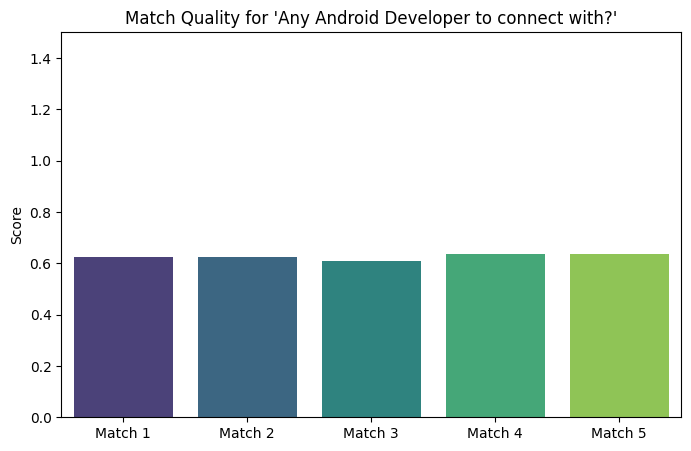

In [ ]:
# Cell 11: Visualize match quality
def plot_match_quality(user_idx, prompt):
    matches, explanations = recommend_with_prompt(user_idx, prompt)
    scores = [float(exp.split("Score=")[1].split(",")[0]) for exp in explanations]
    labels = [f"Match {i+1}" for i in range(len(scores))]
    
    plt.figure(figsize=(8, 5))
    sns.barplot(x=labels, y=scores, palette='viridis')
    plt.title(f"Match Quality for '{prompt}'")
    plt.ylabel("Score")
    plt.ylim(0, 1.5) # Adjust based on score range
    plt.show()

# Test visualization
plot_match_quality(100, "Any Android Developer to connect with?")